# EDA - Crime statistics in Poland between the years 1999-2021

The following project is to test exploratory data analysis techniques.<br>
Data originates from an open public repository maintained by the Polish government - [dane.gov.pl](https://dane.gov.pl) <br>
Data used in this project were collected by the police. They contain information about crimes and offences committed in Poland. <br>
Labels and column names needed to be translated into English to reach a wider audience.

In [59]:
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import colorcet as cc
from sklearn import preprocessing
pd.set_option('display.max_columns', None)
path = r'./data/raw/Dane_o_przestepczosci_w_latach_19992021/' # path for data import
viz_path =  r'./src/visualization/' # path to save visualisations

In [60]:
"""
This fragment was used to trim folder names in data imported from public repository.
It should be only run once on freshly unpacked data.
""";

# for (dirpath, dirnames, filenames) in os.walk(path):
#     for filename in filenames:
#         re1= r'^(.*?) wg'
#         re2= '([^\/]+$)'
#         cutname = re.compile("(%s|%s)" % (re1, re2)).findall(dirpath)
        
#         if not (exists(cutname[0][1])):
#             os.rename(dirpath, cutname[0][1])
#         else:
#             os.rename(dirpath, cutname[0][1] + " cd")

## Data loading and improving readability

Only some folders in the dataset contain information that could fit into this analysis.
Folders with the most common crimes for each voivodeship and for Warsaw were collected.

In [61]:
crimes = pd.DataFrame()
for (dirpath, dirnames, filenames) in os.walk(path): # loading selected crimes statistics into the dataframe
    for filename in filenames:
        if re.search("przestepstwa", filename) is not None:
            crime = re.findall(r"(?<=_)\w+", filename)
            df_name = pd.read_csv(r"{}".format(dirpath+"/"+filename), sep=';', skiprows=2, usecols=[*range(0,4)], encoding = 'cp1250')
            df_name['Type']= str(crime[0])
            crimes = pd.concat([crimes, df_name], ignore_index=True)
            

crimes = crimes.dropna()
crimes = crimes.rename(columns={'Jednostka podziału administracyjnego':'Area', 'Rok':'Year',
                                'Przestępstwa stwierdzone':'Crimes established', 'Przestępstwa wykryte':'Crimes detected'}) # renaming columns to english

crimes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6118 entries, 0 to 6160
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Area                6118 non-null   object 
 1   Year                6118 non-null   float64
 2   Crimes established  6118 non-null   object 
 3   Crimes detected     6118 non-null   object 
 4   Type                6118 non-null   object 
dtypes: float64(1), object(4)
memory usage: 286.8+ KB


A quick peek into the Crimes dataframe shows there are no null values to be deleted or replaced.

In [62]:
"""
Crimes translations
"""
eng_names = {'kradziez':'theft', 'kradziez_samochodu':'car theft', 'włamania':'break-in', 'nietrzezwi':'DUI',
       'bojka':'fight', 'drogowe':'traffic offences', 'gospodarcze':'economic crimes', 'korupcja':'corruption', 'kryminalne':'criminal offences',
       'uszczerbek':'personal injury', 'uszkodzenie':'property damage', 'zabojstwo':'homicide', 'zgwalcenie':'rape'}
crimes = crimes.replace({"Type": eng_names})
list_of_crimes = crimes['Type'].unique().tolist()
list_of_crimes

['theft',
 'car theft',
 'break-in',
 'DUI',
 'fight',
 'traffic offenses',
 'economic crimes',
 'corruption',
 'criminal offences',
 '17x7',
 'personal injury',
 'property damage',
 'homicide',
 'rape']

In [63]:
"""
Administrative unit names tweaking
"""
simplified_Area = {'Polska':'Poland', 'woj. dolnośląskie':'dolnośląskie', 'woj. kujawsko-pomorskie':'kujawsko-pomorskie',
       'woj. lubelskie':'lubelskie', 'woj. lubuskie':'lubuskie', 'woj. łódzkie':'łódzkie',
       'woj. małopolskie':'małopolskie',
       'woj. mazowieckie (KWP z/s w Radomiu i KSP Warszawa)':'mazowieckie',
       'woj. opolskie':'opolskie', 'woj. podkarpackie':'podkarpackie', 'woj. podlaskie':'podlaskie',
       'woj. pomorskie':'pomorskie', 'woj. śląskie':'śląskie', 'woj. świętokrzyskie':'świętokrzyskie',
       'woj. warmińsko-mazurskie':'warmińsko-mazurskie', 'woj. wielkopolskie':'wielkopolskie',
       'woj. zachodniopomorskie':'zachodniopomorskie', 'teren działania KWP z/s w Radomiu':'Radom',
       'teren działania KSP Warszawa':'Warsaw'}
crimes = crimes.replace({"Area": simplified_Area})
crimes['Area'].unique().tolist()

['Poland',
 'dolnośląskie',
 'kujawsko-pomorskie',
 'lubelskie',
 'lubuskie',
 'łódzkie',
 'małopolskie',
 'mazowieckie',
 'opolskie',
 'podkarpackie',
 'podlaskie',
 'pomorskie',
 'śląskie',
 'świętokrzyskie',
 'warmińsko-mazurskie',
 'wielkopolskie',
 'zachodniopomorskie',
 'Radom',
 'Warsaw']

In [64]:
"""
A number of crimes are imported as a string with space as a thousand separator.
For further analysis, spaces need to be removed first, and then each value can be converted to an integer number.
The year column format should contain year DateTime values only. Formatting is applied to it to achieve it.
Also, the crime type '17x7' and 'criminal offences' aren't relevant to this analysis.
"""

crimes['Crimes detected'] = crimes['Crimes detected'].str.replace(' ', '')
crimes['Crimes detected'] = pd.to_numeric(crimes['Crimes detected'], errors='coerce')
crimes['Crimes established'] = crimes['Crimes established'].str.replace(' ', '')
crimes['Crimes established'] =  pd.to_numeric(crimes['Crimes established'], errors='coerce')
crimes['Year'] = pd.to_datetime(crimes['Year'].map('{:.0f}'.format), format='%Y')
crimes['Year'] = crimes['Year'].dt.year
crimes = crimes[crimes['Type']!='17x7'] # 17x7 means 7 most common crimes together so it can be skipped as it can
crimes = crimes[crimes['Type']!='criminal offences'] # criminal offences is too vague to properly analyse
crimes.dropna(inplace=True)
crimes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5206 entries, 0 to 6160
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Area                5206 non-null   object 
 1   Year                5206 non-null   int64  
 2   Crimes established  5206 non-null   float64
 3   Crimes detected     5206 non-null   float64
 4   Type                5206 non-null   object 
dtypes: float64(2), int64(1), object(2)
memory usage: 244.0+ KB


To have consistent colour on the data visualisations, the dictionary with assigned colours to the crime type is created below:

In [65]:
colors = sns.color_palette(cc.glasbey, n_colors=len(list_of_crimes)).as_hex()
palette = dict(zip(list_of_crimes, colors))
palette

{'theft': '#d60000',
 'car theft': '#8c3bff',
 'break-in': '#018700',
 'DUI': '#00acc6',
 'fight': '#97ff00',
 'traffic offenses': '#ff7ed1',
 'economic crimes': '#6b004f',
 'corruption': '#ffa52f',
 'criminal offences': '#573b00',
 '17x7': '#005659',
 'personal injury': '#0000dd',
 'property damage': '#00fdcf',
 'homicide': '#a17569',
 'rape': '#bcb6ff'}

## Crimes in Warsaw

In the first step, the data filtered to Warsaw is analysed.

In [66]:
warsaw_crimes = crimes[crimes['Area']=='Warsaw']
warsaw_crimes.reset_index(inplace=True, drop=True)
warsaw_crimes.head()

,Area,Year,Crimes established,Crimes detected,Type
0,Warsaw,2021,18642.0,4258.0,theft
1,Warsaw,2020,15954.0,3550.0,theft
2,Warsaw,2019,18706.0,3976.0,theft
3,Warsaw,2018,17386.0,3738.0,theft
4,Warsaw,2017,17441.0,3608.0,theft


First, the total sum of each crime for Warsaw is visualised to show which most common offences.

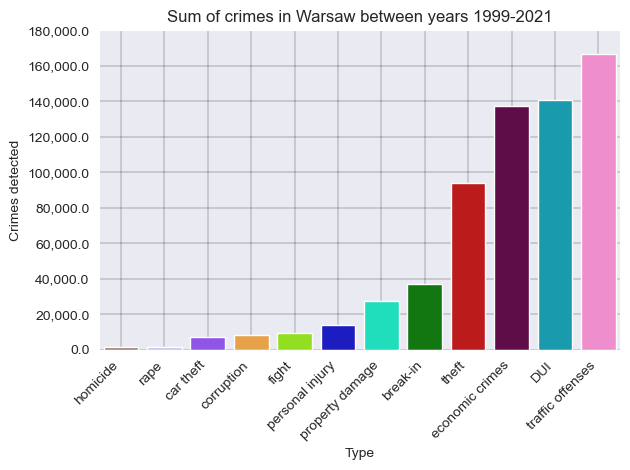

In [75]:
"""
Printing chart with total sum for each crime type
"""
label_format = '{:,}' # format for thousnad separator

sum_warsaw_crime = warsaw_crimes.groupby('Type')['Crimes detected'].sum().sort_values().to_frame().reset_index()

ax = sns.barplot(data=sum_warsaw_crime, x="Type", y="Crimes detected", palette=palette)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

ticks_loc = ax.get_yticks().tolist()
ax.set_yticks(ax.get_yticks().tolist())
ax.set_yticklabels([label_format.format(x) for x in ticks_loc])

plt.title("Sum of crimes in Warsaw between years 1999-2021")
plt.tight_layout()
plt.grid(color='k', linewidth=0.2)
plt.savefig(viz_path+'Barchart_warsaw_crimes.png')

Charts shows that most common crimes in Warsaw during 22 years were traffic offences, DUI and economic crimes.
Such massive number of DUIs can be especially scary in terms of safety on roads and fight with alcoholism and drugs.
On the other hand crimes that can result in death or trauma are not that common in Warsaw which can indicate towards the city being relativly safe.

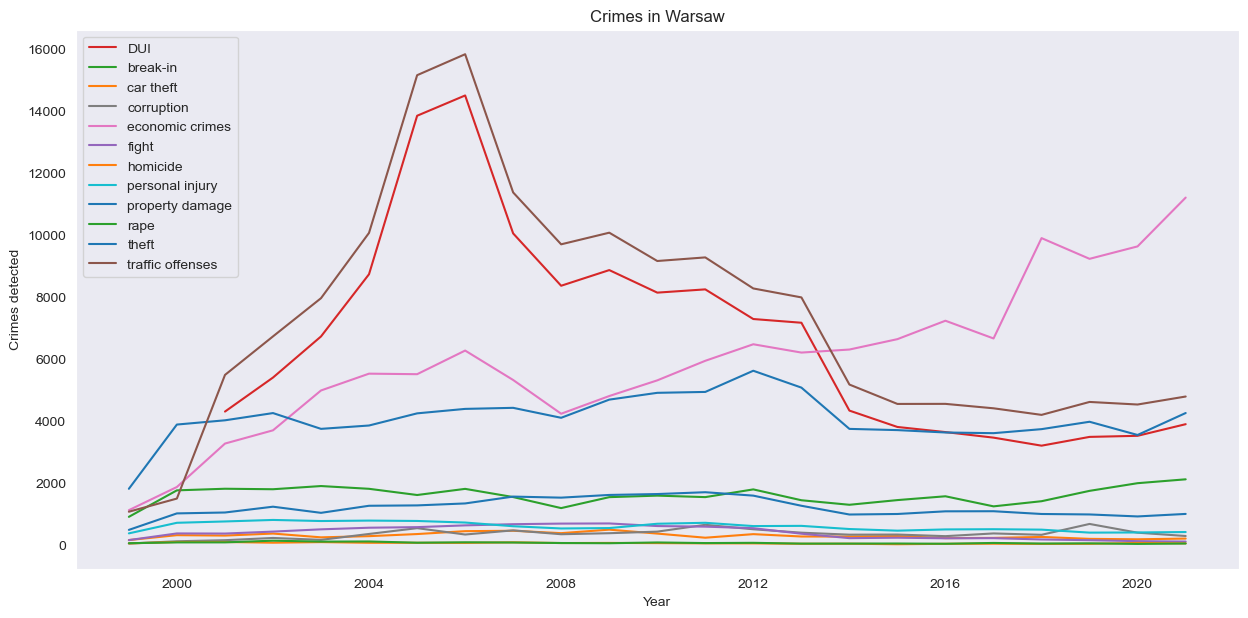

In [32]:
"""
Changes in the number of crimes per year broken down by type
"""

fig2, ax2 = plt.subplots(figsize=(15,7))
grouped_df = warsaw_crimes.groupby(['Type', 'Year'])[["Crimes detected"]].sum().reset_index()
sns.lineplot(data=grouped_df, x="Year", y="Crimes detected", hue="Type", legend="auto", palette=palette)
plt.title('Crimes in Warsaw')
plt.legend(loc='best')
plt.grid()
plt.show()

In [23]:
grouped_df_rarercimres = grouped_df[grouped_df["Crimes detected"] < 3000]
grouped_df_rarercimres['Type'].unique()

array(['break-in', 'car theft', 'corruption', 'economic crimes', 'fight',
       'homicide', 'personal injury', 'property damage', 'rape', 'theft',
       'traffic offenses'], dtype=object)

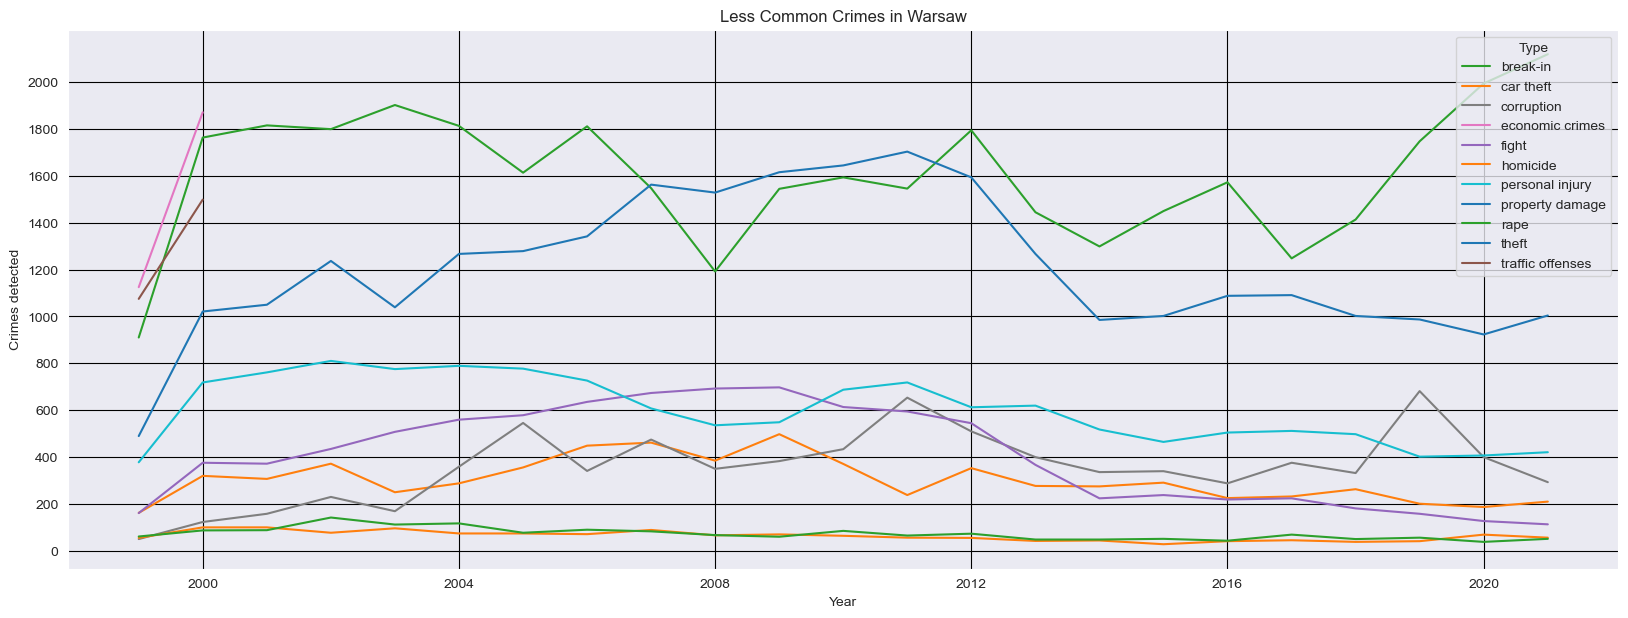

In [33]:
fig3, ax3 = plt.subplots(figsize=(20,7))

grouped_df = warsaw_crimes.groupby(['Type', 'Year'])[["Crimes detected"]].sum().reset_index()
grouped_df_rarercimres = grouped_df[grouped_df["Crimes detected"] < 3000]

sns.lineplot(data=grouped_df_rarercimres, x="Year", y="Crimes detected", hue="Type", legend="auto", palette=palette)
plt.yticks(np.arange(0, 2200, step=200))
plt.title('Less Common Crimes in Warsaw')
plt.grid(color='k')
plt.show()

In [35]:
waw_mean_crimes = warsaw_crimes.groupby('Type')['Crimes detected'].mean().sort_values()
waw_mean_crimes = waw_mean_crimes.reset_index()
grouped_df_common_crimes = grouped_df[grouped_df["Crimes detected"] > 3000]
print(waw_mean_crimes)

                Type  Crimes detected
0           homicide        62.086957
1               rape        71.217391
2          car theft       302.130435
3         corruption       356.782609
4              fight       403.217391
5    personal injury       599.086957
6    property damage      1205.391304
7           break-in      1606.304348
8              theft      4095.478261
9    economic crimes      5972.521739
10               DUI      6714.095238
11  traffic offenses      7237.434783


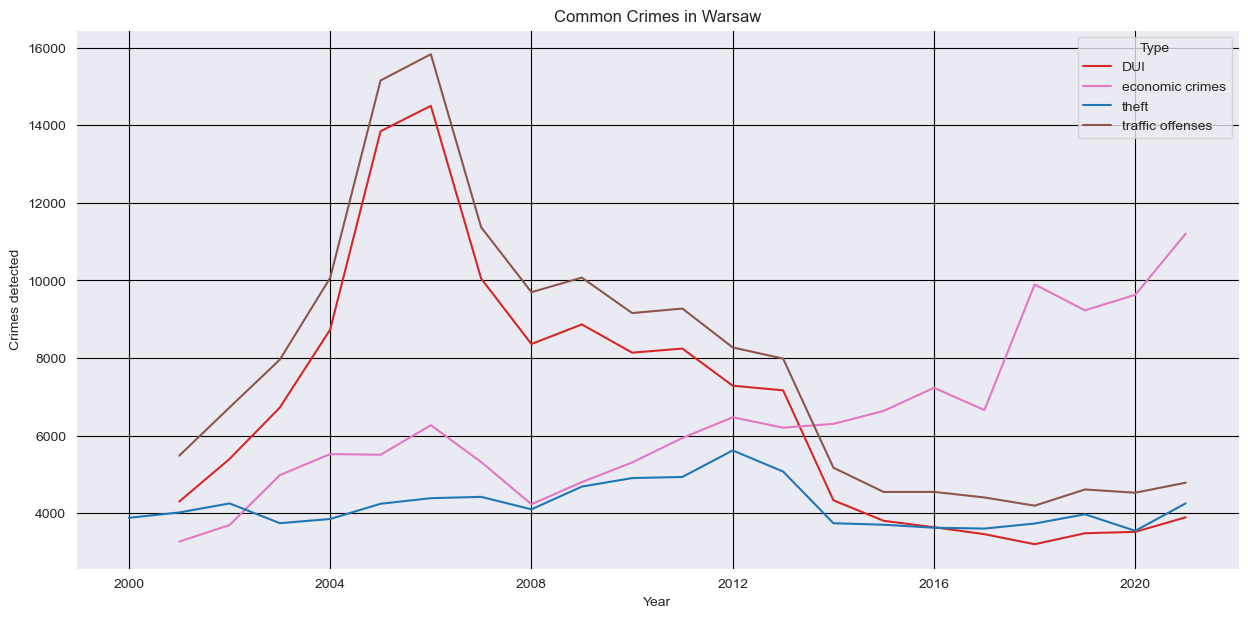

In [36]:
fig4, ax4 = plt.subplots(figsize=(15,7))

sns.lineplot(data=grouped_df_common_crimes, x="Year", y="Crimes detected", hue="Type", legend="auto", palette=palette)
plt.title('Common Crimes in Warsaw')
plt.grid(color='k')
plt.show()

## Crimes in Poland

In [37]:
country_crimes = crimes[crimes['Area']=='Poland']
country_crimes = country_crimes[country_crimes['Type']!='criminal offences']
country_crimes.reset_index(inplace=True, drop=True)
country_crimes.head()

,Area,Year,Crimes established,Crimes detected,Type
0,Poland,2021-01-01,109768.0,43090.0,theft
1,Poland,2020-01-01,98886.0,37699.0,theft
2,Poland,2019-01-01,103910.0,36307.0,theft
3,Poland,2018-01-01,100372.0,33142.0,theft
4,Poland,2017-01-01,108248.0,35359.0,theft


C:\Users\chmie\AppData\Local\Temp\ipykernel_43708\1959587620.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax5.set_yticklabels(['{:,}'.format(int(x)) for x in ax5.get_yticks().tolist()])
C:\Users\chmie\AppData\Local\Temp\ipykernel_43708\1959587620.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax6.set_yticklabels(['{:,}'.format(int(x)) for x in ax6.get_yticks().tolist()])


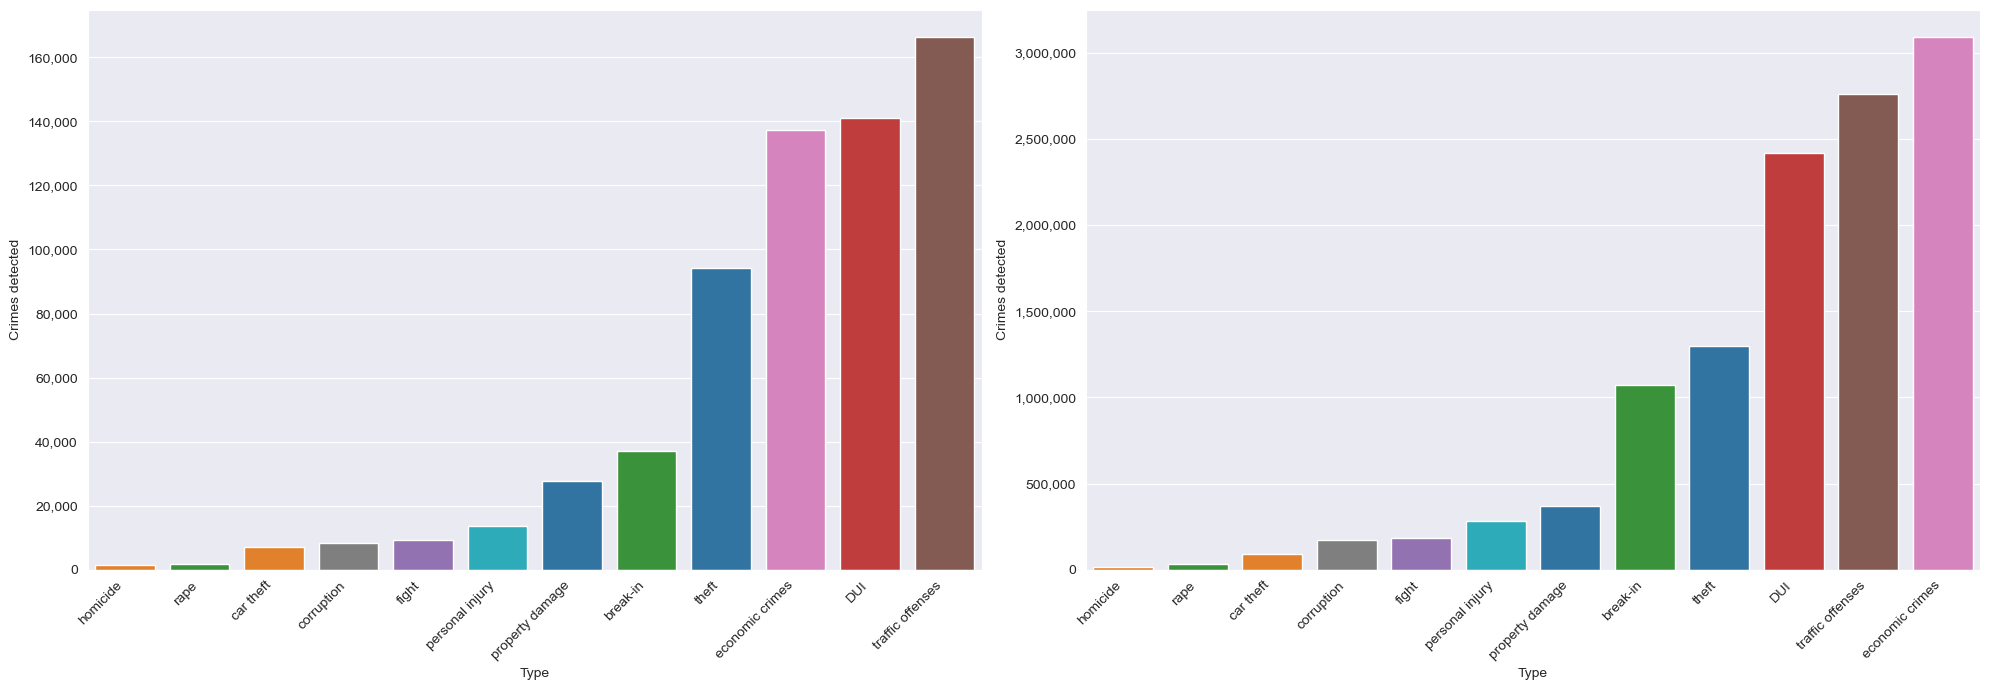

In [38]:
sum_country_crimes = country_crimes.groupby('Type')['Crimes detected'].sum().sort_values().to_frame().reset_index()
fig5, comp_ax = plt.subplots(ncols=2, figsize=(20, 7))
ax5 = sns.barplot(data=sum_country_crimes, x="Type", y="Crimes detected", ax=comp_ax[1], palette=palette)
ax5.set_xticklabels(ax5.get_xticklabels(), rotation=45, ha="right")
ax5.set_yticklabels(['{:,}'.format(int(x)) for x in ax5.get_yticks().tolist()])
ax6 = sns.barplot(data=sum_warsaw_crime, x="Type", y="Crimes detected", ax=comp_ax[0], palette=palette)
ax6.set_xticklabels(ax6.get_xticklabels(), rotation=45, ha="right")
ax6.set_yticklabels(['{:,}'.format(int(x)) for x in ax6.get_yticks().tolist()])
plt.tight_layout()
plt.savefig(viz_path+'Barchart_poland_crimes.png')

In [52]:
min_max_scaler = preprocessing.MinMaxScaler()

scaled_cr_country = min_max_scaler.fit_transform(sum_country_crimes[["Crimes detected"]])
scaled_sum_country_crimes = sum_country_crimes
scaled_sum_country_crimes["Crimes detected"] = scaled_cr_country

scaled_cr_warsaw = min_max_scaler.fit_transform((sum_warsaw_crime[["Crimes detected"]]))
scaled_sum_warsaw_crimes = sum_warsaw_crime
scaled_sum_warsaw_crimes["Crimes detected"] = scaled_cr_warsaw

In [71]:
scaled_crimes = pd.merge(scaled_sum_warsaw_crimes, scaled_sum_country_crimes, on='Type', suffixes=('_warsaw', '_country'))
scaled_crimes = scaled_crimes.rename(columns={"Crimes detected_warsaw": "Warsaw", "Crimes detected_country": "Country"})
melted_crimes = scaled_crimes.melt("Type", var_name="Area", value_name="Crimes detected")
melted_crimes.head()

,Type,Area,Crimes detected
0,homicide,Warsaw,0.000000
1,rape,Warsaw,0.001272
2,car theft,Warsaw,0.033454
3,corruption,Warsaw,0.041071
4,fight,Warsaw,0.047542


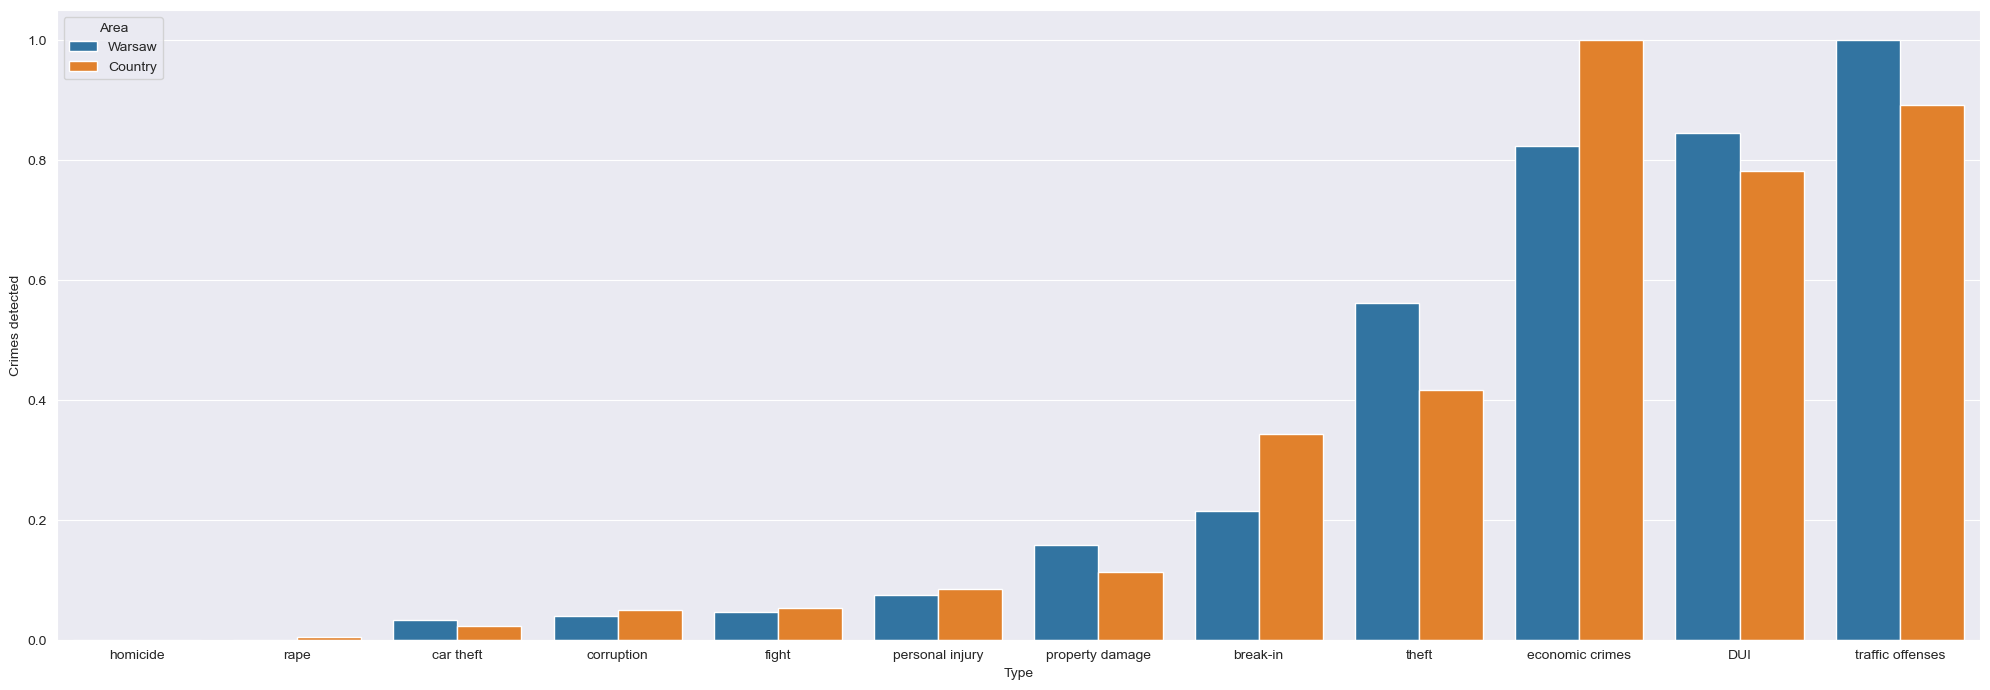

In [77]:
fig6, ax7 = plt.subplots(figsize=(20, 7))
sns.barplot(data=melted_crimes, x="Type", y="Crimes detected", hue="Area")
plt.tight_layout()
# plt.savefig(viz_path+'Barchart_poland_crimes.png')